In [1]:
%config IPCompleter.greedy=True

In [2]:
# ! pip install pandas
# ! pip install matplotlib

In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

### 資料檢視

In [4]:
df = pd.read_csv('kc_house_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [5]:
pd.options.display.max_columns = 10
df.head()

,id,date,price,bedrooms,bathrooms,...,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,...,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,...,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,...,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,...,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,...,98074,47.6168,-122.045,1800,7503


In [6]:
df.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

### 資料轉換

In [7]:
df['year'] = pd.to_numeric(df['date'].str.slice(0, 4))
df['month'] = pd.to_numeric(df['date'].str.slice(4, 6))
df['day'] = pd.to_numeric(df['date'].str.slice(6, 8))
df.drop(['id', 'date'], axis='columns', inplace=True)
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,...,sqft_living15,sqft_lot15,year,month,day
0,221900.0,3,1.00,1180,5650,...,1340,5650,2014,10,13
1,538000.0,3,2.25,2570,7242,...,1690,7639,2014,12,9
2,180000.0,2,1.00,770,10000,...,2720,8062,2015,2,25
3,604000.0,4,3.00,1960,5000,...,1360,5000,2014,12,9
4,510000.0,3,2.00,1680,8080,...,1800,7503,2015,2,18


### 資料打散

In [8]:
data_num = df.shape[0]
indexes = np.random.permutation(data_num)
train_indexes = indexes[:int(data_num * 0.6)]
valid_indexes = indexes[int(data_num * 0.6):int(data_num * 0.8)]
test_indexes = indexes[int(data_num * 0.8):]

In [9]:
train_data = df.loc[train_indexes]
valid_data = df.loc[valid_indexes]
test_data = df.loc[test_indexes]

### 標準化

In [10]:
train_valid_data = pd.concat([train_data, valid_data])
mean = train_valid_data.mean()
std = train_valid_data.std()
train_data = (train_data - mean) / std
valid_data = (valid_data - mean) / std

### 訓練資料

In [11]:
x_train = np.array(train_data.drop('price', axis='columns'))
y_train = np.array(train_data['price'])
x_valid = np.array(valid_data.drop('price', axis='columns'))
y_valid = np.array(valid_data['price'])

In [12]:
x_train.shape

(12967, 21)

### 建立模型

In [13]:
model_1 = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(21,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
], name='model_1')
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1408      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________


### 優化器. 損失函數. 指標函數

In [14]:
model_1.compile(keras.optimizers.Adam(0.01),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.MeanAbsoluteError()])

### 設定 TensorBoard

In [15]:
log_dir = os.path.join('logs', 'model_1')
model_cbs = keras.callbacks.TensorBoard(log_dir=log_dir)

model_dir = 'logs/models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model_mcp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-Model-1.h5',
                                            monitor='val_mean_absolute_error',
                                            save_best_only=True,
                                            mode='min')

### 訓練模型

In [16]:
history = model_1.fit(x_train, y_train,
                    batch_size=64,
                    epochs=300,
                    validation_data=(x_valid, y_valid),
                    callbacks=[model_cbs, model_mcp],
                    verbose=0)

history.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

### 效能指標 (metrics) 折線圖

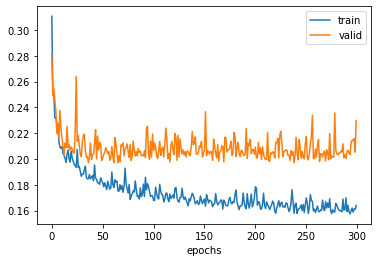

In [17]:
fig = plt.figure()
plt.plot(history.history['mean_absolute_error'], label='train')
plt.plot(history.history['val_mean_absolute_error'], label='valid')
plt.xlabel('metrics')
plt.xlabel('epochs')
plt.legend(loc='upper right')

### 損失值 (loss) 折線圖

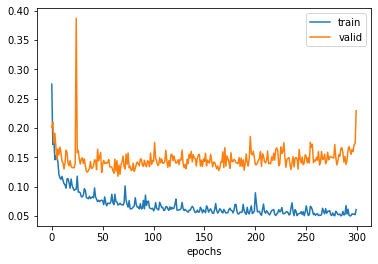

In [18]:
fig = plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.xlabel('metrics')
plt.xlabel('epochs')
plt.legend(loc='upper right')

### 測試資料誤差百分比

In [19]:
model_1.load_weights('logs/models/Best-Model-1.h5')
y_test = np.array(test_data['price'])
test_data = (test_data - mean) / std
x_test = np.array(test_data.drop('price', axis='columns'))
y_pred = model_1.predict(x_test)
print(y_pred.shape)
y_pred = np.reshape(y_pred * std['price'] + mean['price'], y_test.shape)
percentage_error = np.mean(np.abs(y_test - y_pred)) / np.mean(y_test) * 100
f'model_1 percentage error: {percentage_error:.2f}%'

(4323, 1)


'model_1 percentage error: 13.79%'

### 載入 TensorBoard 

In [20]:
%load_ext tensorboard
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 11676), started 0:03:22 ago. (Use '!kill 11676' to kill it.)